In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import torch
import argparse
import pathlib
import time

from learn_embedding import train
from core.EmbeddingDataSet import EmbeddingDataSet
from core.GraphConvNet import GraphConvNet
from util.training_utils import save_metadata, save_train_log
from util.plot_graph_embedding import plot_graph_embedding
from util.network_utils import get_net_projection

cuda not available
cuda not available
cuda not available


/home/zk/anaconda3/envs/gbert/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
input_dir = 'data'
output_dir = 'results'
dataset_name = 'cora'

In [4]:
# Here we set the graph clustering weight (alpha) at 0.4, as in the paper
opt_parameters = {'graph_weight': 0.4}
opt_parameters['learning_rate'] = 0.00075  # ADAM
opt_parameters['max_iters'] = 240
opt_parameters['batch_iters'] = 40
opt_parameters['save_flag'] = True
opt_parameters['decay_rate'] = 1.25
opt_parameters['start_epoch'] = 0

opt_parameters['distance_metric'] = 'cosine'
opt_parameters['n_batches'] = 1
opt_parameters['shuffle_flag'] = False
opt_parameters['sampling_flag'] = False
opt_parameters['val_batches'] = 1
opt_parameters['perplexity'] = 30

dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.summarise()

task_parameters = {}
task_parameters['n_components'] = 2
task_parameters['val_flag'] = True

net_parameters = {}
net_parameters['n_components'] = task_parameters['n_components']
net_parameters['D'] = dataset.input_dim  # input dimension
net_parameters['H'] = 128  # number of hidden units
net_parameters['L'] = 2  # number of hidden layers

# Initialise network
net = GraphConvNet(net_parameters)
if torch.cuda.is_available():
    net.cuda()

# Create checkpoint dir
subdirs = [x[0] for x in os.walk(output_dir) if dataset_name in x[0]]
run_number = str(len(subdirs) + 1)
checkpoint_dir = os.path.join(output_dir, dataset_name + '_' + run_number)
pathlib.Path(checkpoint_dir).mkdir(exist_ok=True)  # create the directory if it doesn't exist

print("Number of network parameters = {}".format(net.nb_param))
print('Saving results into: {}'.format(checkpoint_dir))

# Start training here
t_start = time.time()
val_dataset = None
if task_parameters['val_flag']:
    val_dataset = EmbeddingDataSet(dataset_name, input_dir, train=False)

tab_results = train(net, dataset, opt_parameters, checkpoint_dir, val_dataset)

end_epoch = opt_parameters['start_epoch'] + opt_parameters['max_iters']

if opt_parameters['save_flag']:
    save_metadata(checkpoint_dir, task_parameters, net_parameters, opt_parameters, end_epoch)
    save_train_log(checkpoint_dir, tab_results, end_epoch)
    
t_elapsed = time.time() - t_start
print("Time elapsed = {:.4f}".format(t_elapsed))

Name of dataset = cora
Input dimension = 1433
Number of training samples = 2708
Training labels = True
Number of network parameters = <bound method GraphConvNet.nb_param of GraphConvNet(
  (gnn_cells): ModuleList(
    (0): GraphConvNetCell(
      (Ui1): Linear(in_features=1433, out_features=128, bias=False)
      (Uj1): Linear(in_features=1433, out_features=128, bias=False)
      (Vi1): Linear(in_features=1433, out_features=128, bias=False)
      (Vj1): Linear(in_features=1433, out_features=128, bias=False)
      (Ui2): Linear(in_features=128, out_features=128, bias=False)
      (Uj2): Linear(in_features=128, out_features=128, bias=False)
      (Vi2): Linear(in_features=128, out_features=128, bias=False)
      (Vj2): Linear(in_features=128, out_features=128, bias=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R): Linear(in_features=1

Data blocks of length:  [2708]
Time to create all data (s) = 0.0191


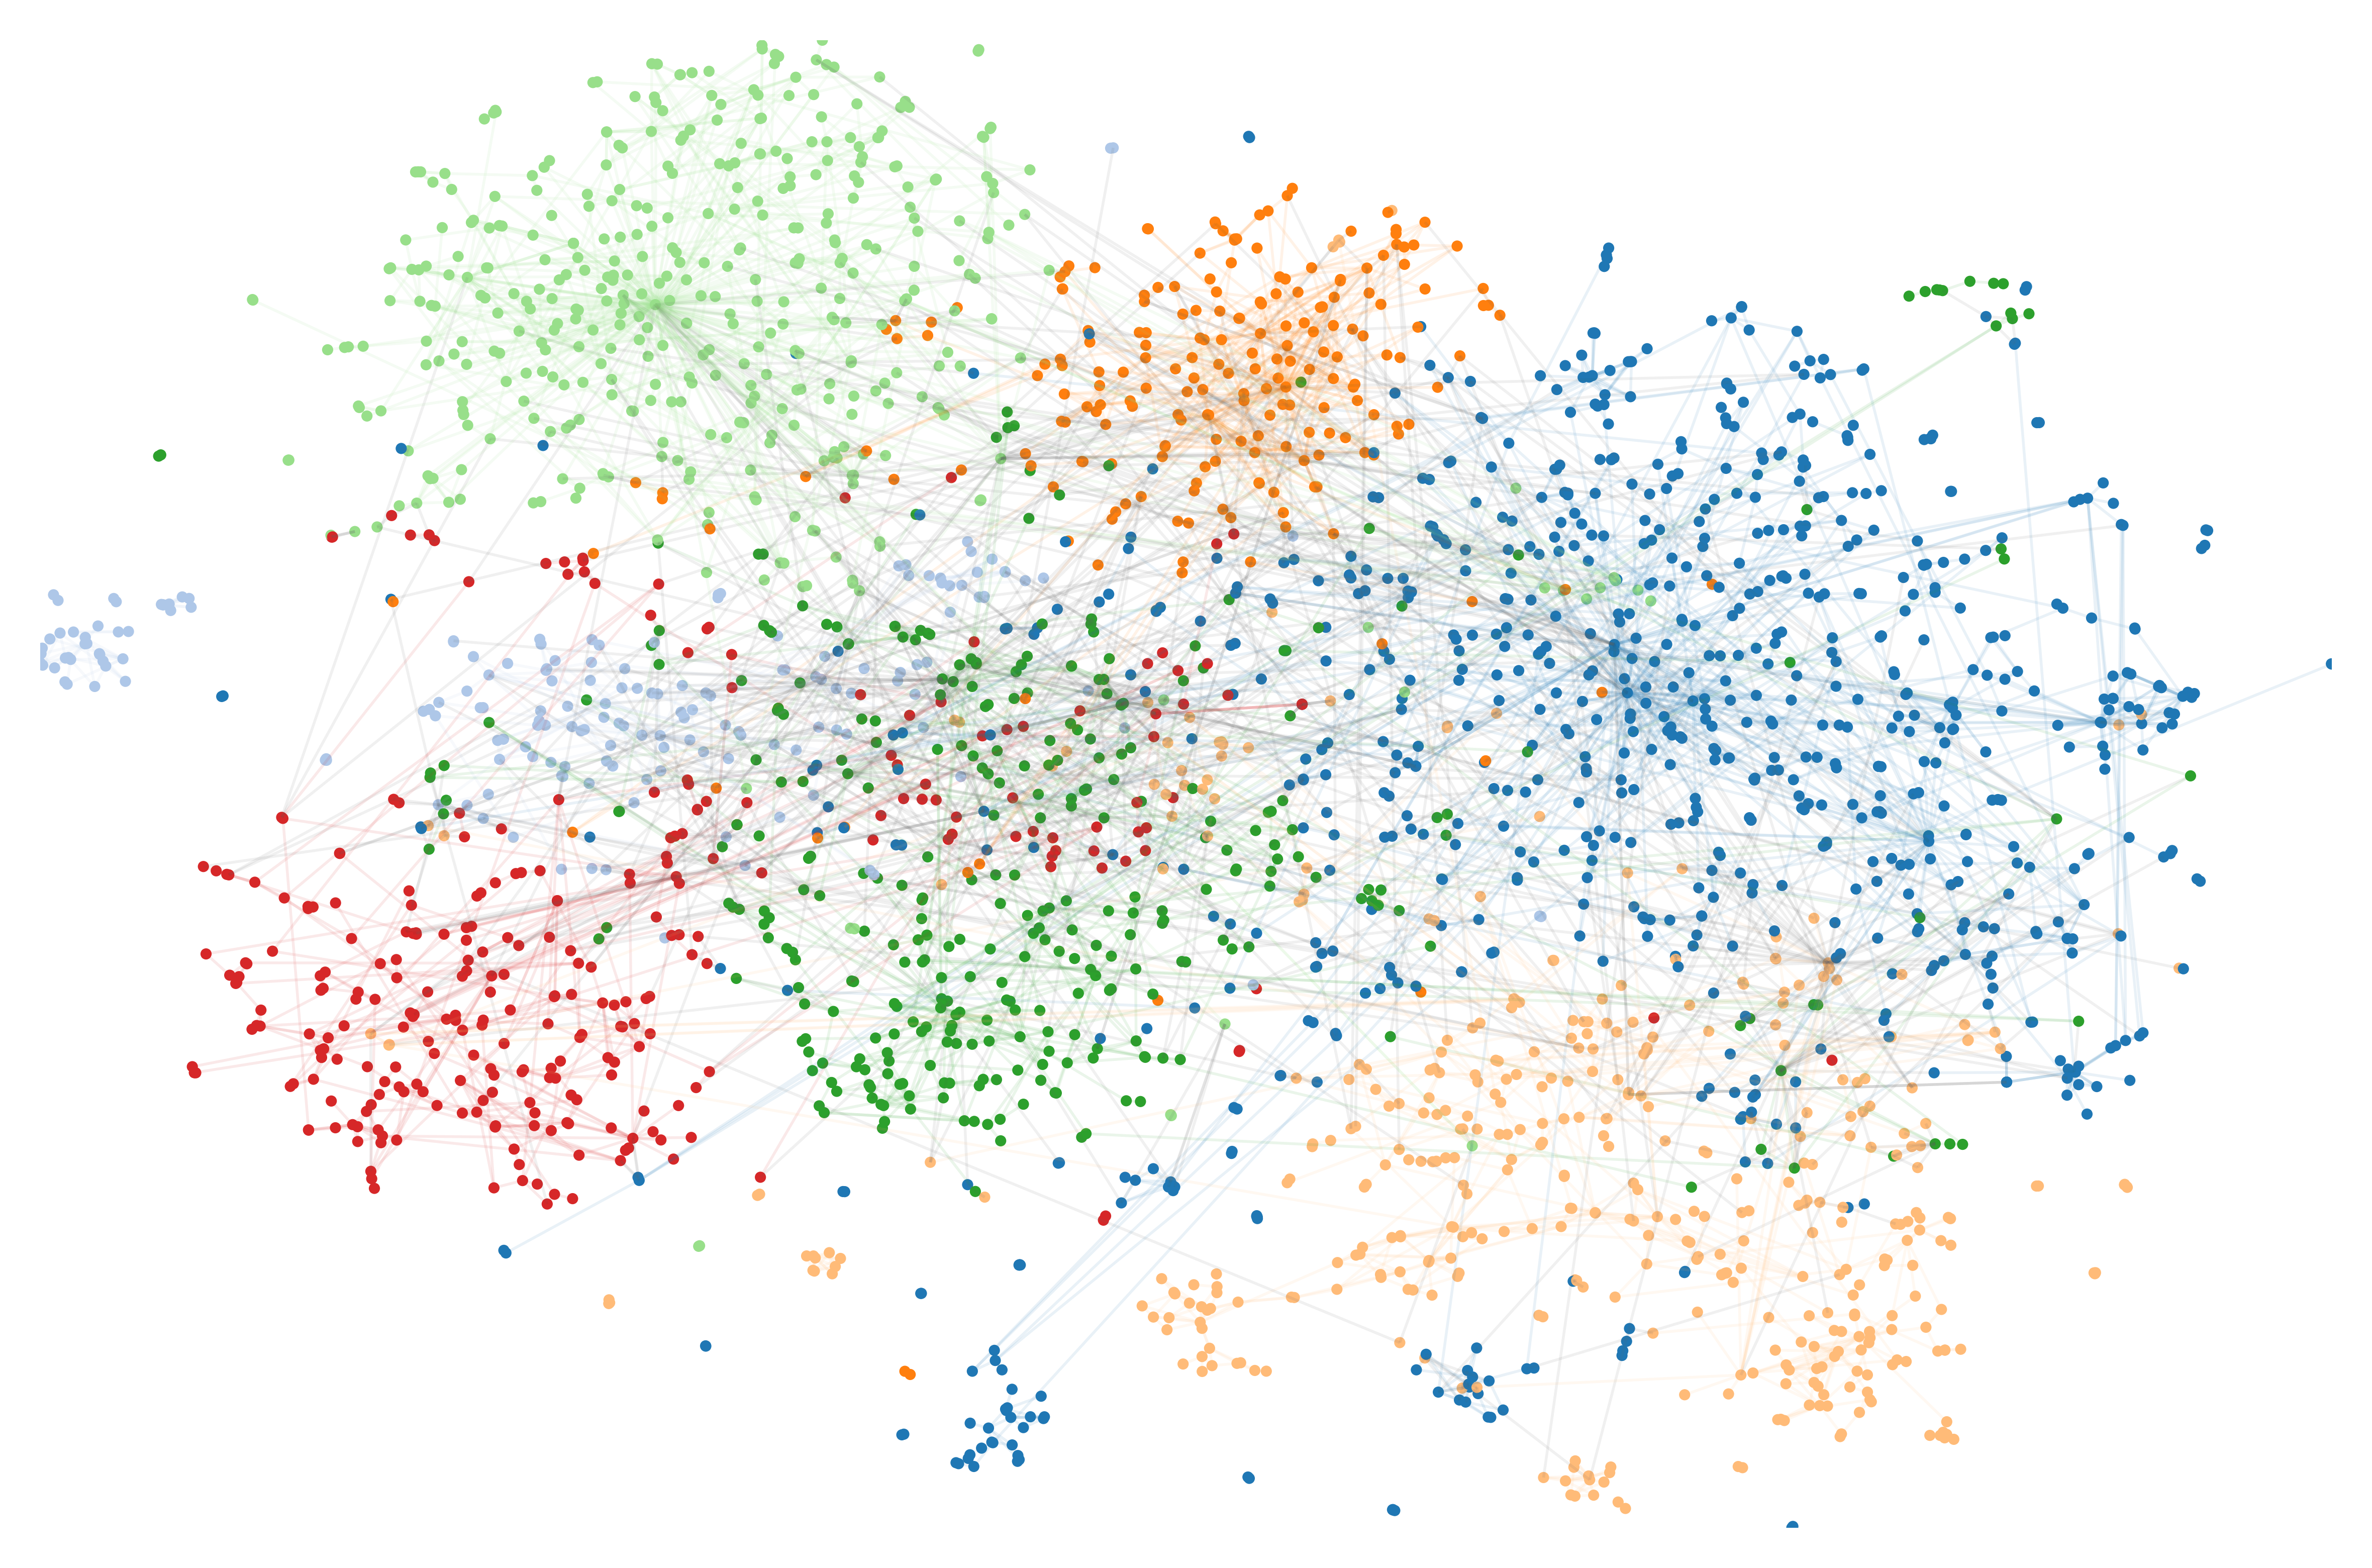

In [5]:
y_pred = get_net_projection(net, dataset)
plot_graph_embedding(y_pred, dataset.labels, dataset.adj_matrix, line_alpha=0.05, s=1)